In [41]:
import netCDF4 as nc
import os
import numpy as np
import pandas as pd
import re
import csv
import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
file_dir = r'../observation'
filename_list = os.listdir(file_dir)
filenames = [f for f in filename_list if f.endswith('.csv')]
filenames

['时数据 202309月 气温.csv',
 '时数据 202309月降水.csv',
 '时数据 202310月 气温.csv',
 '时数据 202310月 降雨.csv',
 '时数据202311月 气温.csv',
 '时数据202311月 降水.csv',
 '时数据202312月气温.csv',
 '时数据202312月降水.csv',
 '时数据202401月气温.csv',
 '时数据202401月降水.csv',
 '时数据202402月气温.csv',
 '时数据202402月降水.csv',
 '时数据202403月气温.csv',
 '时数据202403月降水.csv',
 '时数据202404月气温.csv',
 '时数据202404月降水.csv',
 '时数据202405月气温.csv',
 '时数据202405月降水.csv',
 '时数据202406月气温.csv',
 '时数据202406月降水.csv',
 '时数据202407月气温.csv',
 '时数据202407月降水.csv',
 '时数据202408月气温.csv',
 '时数据202408月降水.csv']

In [3]:
import re
import chardet

def extract_time_from_filename(filename, pattern):
    """
    从文件名中提取时间信息（YYYYMM格式，不包括月字）。

    参数:
    filename (str): 包含时间信息的文件名。

    返回:
    str: 提取到的时间信息，如果未找到则返回None。
    """
    # 正则表达式模式，用于匹配6个连续的数字（YYYYMM格式，但不包括月字）
    
    # 使用re.search查找匹配项
    match = re.search(pattern, filename)
    
    # 如果找到匹配项，则提取时间信息
    if match:
        return match.group(0)
    else:
        return None

def get_encoding(filepath):
    # 读取文件的前几个字节来检测编码
    with open(filepath, 'rb') as f:
        raw_data = f.read(10000)  # 读取前10000个字节通常足够检测编码
        result = chardet.detect(raw_data)
        
    return result['encoding']

In [4]:
filenames

['时数据 202309月 气温.csv',
 '时数据 202309月降水.csv',
 '时数据 202310月 气温.csv',
 '时数据 202310月 降雨.csv',
 '时数据202311月 气温.csv',
 '时数据202311月 降水.csv',
 '时数据202312月气温.csv',
 '时数据202312月降水.csv',
 '时数据202401月气温.csv',
 '时数据202401月降水.csv',
 '时数据202402月气温.csv',
 '时数据202402月降水.csv',
 '时数据202403月气温.csv',
 '时数据202403月降水.csv',
 '时数据202404月气温.csv',
 '时数据202404月降水.csv',
 '时数据202405月气温.csv',
 '时数据202405月降水.csv',
 '时数据202406月气温.csv',
 '时数据202406月降水.csv',
 '时数据202407月气温.csv',
 '时数据202407月降水.csv',
 '时数据202408月气温.csv',
 '时数据202408月降水.csv']

In [109]:
data_dict = {}
for filename in filenames:
    filepath = os.path.join(file_dir, filename)
    #
    encoding = get_encoding(filepath)
    #
    df_temp = pd.read_csv(filepath, sep=',', encoding=encoding, nrows=2)
    #
    data_temp = df_temp.iloc[:, 3:-8]
    
    #
    ym_string = extract_time_from_filename(filename, pattern=r'\d{6}')
    
    data_type = '气温' if '气温' in filename else ('降水' if '降水' in filename else None)
    
    if data_type:
        if data_type not in data_dict:
            data_dict[data_type] = {'data':[], 'time':[]}
        
        string_array = data_temp.columns.values
        lst_time = []
        for string in string_array:
            string_temp = ym_string + string[0: 2] + string[3: 5]
            lst_time.append(string_temp)
            
        # save data
        time_axis = pd.to_datetime(lst_time, format='%Y%m%d%H').astype('int64').values
        data = data_temp.values
        
        # 
        data_dict[data_type]['data'].append(data)
        data_dict[data_type]['time'].append(time_axis)

In [110]:
data_dict.keys()

dict_keys(['气温', '降水'])

In [130]:
# 海威1号
temp_time_raw = np.concatenate(data_dict['气温']['time'])
temp_raw = np.concatenate(data_dict['气温']['data'], axis=1)[0]
print(len(temp_time_raw), len(temp_raw))

rain_time_raw = np.concatenate(data_dict['降水']['time'])
rain_raw = np.concatenate(data_dict['降水']['data'], axis=1)[0]
print(len(rain_time_raw), len(rain_raw))

8784 8784
8040 8040


In [136]:
# 检查是否有遗漏的时间并构建时间轴方便后续插值
time_s = pd.to_datetime(temp_time_raw)[0]
time_e = pd.to_datetime(temp_time_raw).values[-1]
time_axis = pd.date_range(pd.Timestamp(time_s), pd.Timestamp(time_e), freq='h').to_numpy()
print(time_axis.shape)

(8784,)


In [159]:
# 找出nan值索引---temp
nan_indices = np.where(np.isnan(temp_raw))[0]
print(nan_indices)
# 找出缺失值索引
null_indices = np.where(np.isnan(temp_raw))[0]
print(null_indices)

# 剔除
temp_drop = pd.DataFrame(temp_raw).drop(null_indices)
temp_time_drop = pd.DataFrame(temp_time_raw).drop(null_indices)

print(len(temp_raw), len(temp_time_raw))
print(len(temp_drop), len(temp_time_drop))

[4166 4167 4168 4169 4911 4912 4913 4914 5077 5125 5126 5127 5150 5175
 5199 5200 5201 5439]
[4166 4167 4168 4169 4911 4912 4913 4914 5077 5125 5126 5127 5150 5175
 5199 5200 5201 5439]
8784 8784
8766 8766


In [160]:
# 找出nan值索引---rain
nan_indices = np.where(np.isnan(rain_raw))[0]
print(nan_indices)
# 找出缺失值索引
null_indices = np.where(np.isnan(rain_raw))[0]
print(null_indices)

# 剔除
rain_drop = pd.DataFrame(rain_raw).drop(null_indices)
rain_time_drop = pd.DataFrame(rain_time_raw).drop(null_indices)

print(len(rain_raw), len(rain_time_raw))
print(len(rain_drop), len(rain_time_drop))

[ 612  613 5697 5923 7909 7937]
[ 612  613 5697 5923 7909 7937]
8040 8040
8034 8034


In [161]:
# 线性插值补全数据
# 目标插值时间
time_axis_target = np.array(time_axis).astype('int64')

In [164]:
#
interp_func_temp = interp1d(temp_time_drop.squeeze(), temp_drop.squeeze(), bounds_error=False)
interp_func_rain = interp1d(rain_time_drop.squeeze(), rain_drop.squeeze(), bounds_error=False)

In [165]:
#
interpolated_temp = interp_func_temp(time_axis_target)
interpolated_rain = interp_func_rain(time_axis_target)

In [168]:
interpolated_temp.shape, interpolated_rain.shape, time_axis_target.shape

((8784,), (8784,), (8784,))

In [169]:
# 检验
print((np.isnan(interpolated_temp)).all())
print((np.isnan(interpolated_rain)).all())

False
False


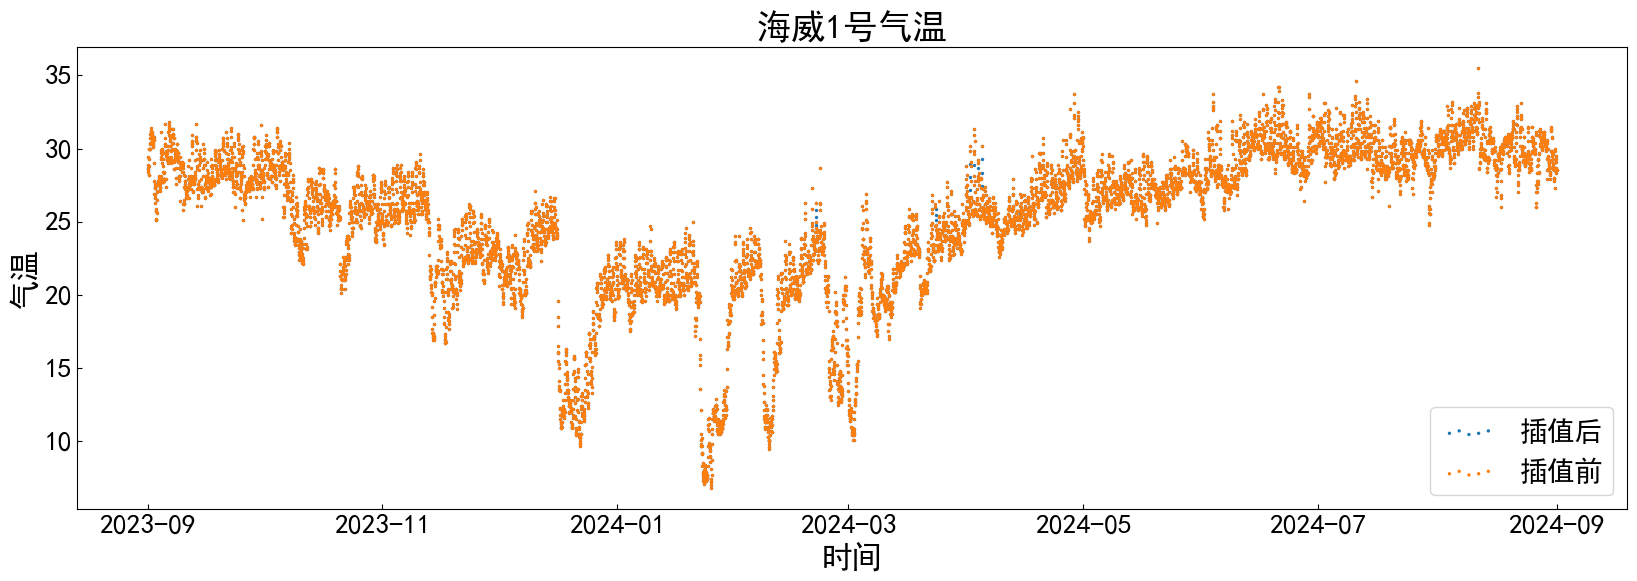

In [173]:
# 绘图检查数据，插值前后对比图
# 设置Matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
size = 2
line_width = 1

plt.figure(figsize=(20, 6))

plt.scatter(pd.to_datetime(time_axis_target), interpolated_temp, linewidth = line_width, s=size, label = '插值后')
plt.scatter(pd.to_datetime(temp_time_raw), temp_raw, linewidth = line_width, s=size, label = '插值前')

plt.tick_params(direction='in', labelsize=20)
plt.xlabel('时间', fontsize=22)
plt.ylabel('气温', fontsize=22)
plt.legend(scatterpoints = 5, loc='lower right', fontsize=20)
plt.title('海威1号气温', fontsize=25)
# plt.savefig('../pic_01/海威1号风速（瞬时风速）', dpi=300, bbox_inches='tight')
plt.show()

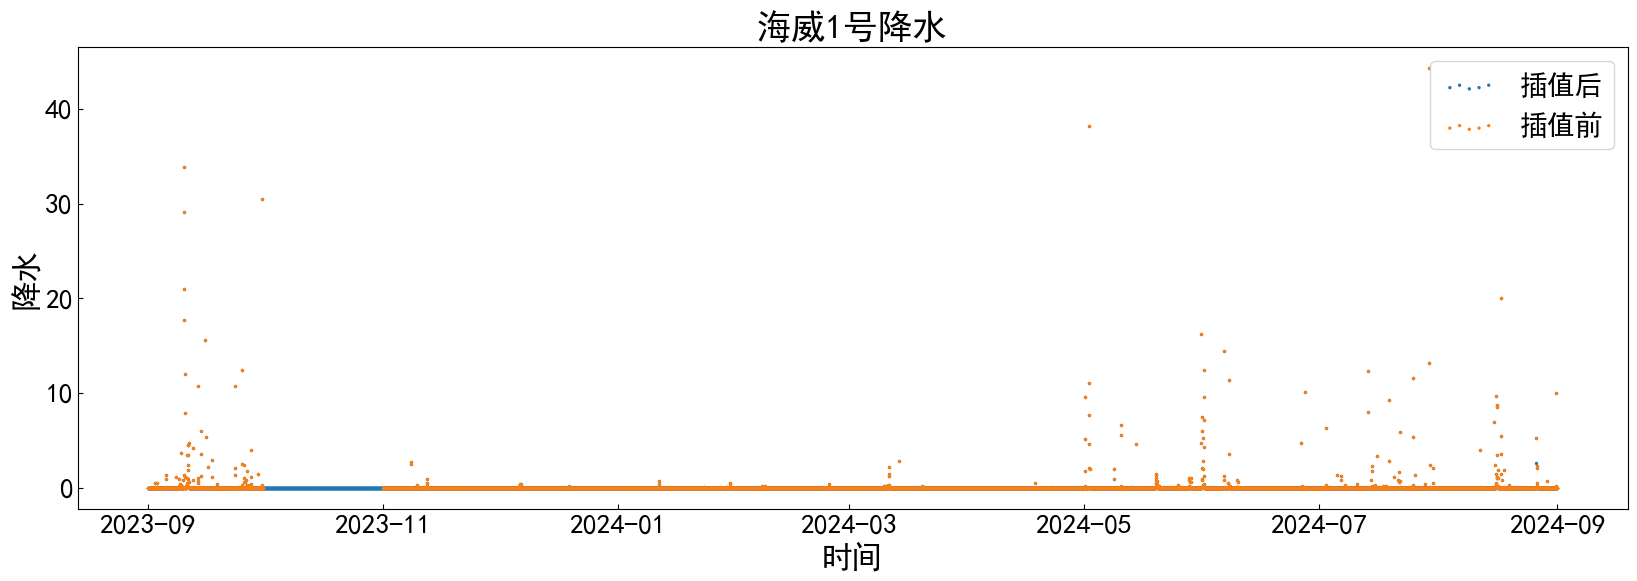

In [174]:
# 绘图检查数据
# 设置Matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
size = 2
line_width = 1

plt.figure(figsize=(20, 6))

plt.scatter(pd.to_datetime(time_axis_target), interpolated_rain, linewidth = line_width, s=size, label = '插值后')
plt.scatter(pd.to_datetime(rain_time_raw), rain_raw, linewidth = line_width, s=size, label = '插值前')

plt.tick_params(direction='in', labelsize=20)
plt.xlabel('时间', fontsize=22)
plt.ylabel('降水', fontsize=22)
plt.legend(scatterpoints = 5, loc='upper right', fontsize=20)
plt.title('海威1号降水', fontsize=25)
# plt.savefig('../pic_01/海威1号风速（瞬时风速）', dpi=300, bbox_inches='tight')
plt.show()

In [175]:
# 保存数据
with open('../data_target_01/observation_temp_rain_time.pkl', 'wb') as f:
    pickle.dump(time_axis_target, f)

In [176]:
# 
with open('../data_target_01/observation_temp_rain.pkl', 'wb') as f:
    pickle.dump({'temp': interpolated_temp, 'rain': interpolated_rain}, f)

# Test

In [97]:
for filename in filenames[0:1]:
    filepath = os.path.join(file_dir, filename)
    #
    encoding = get_encoding(filepath)
    #
    df_temp = pd.read_csv(filepath, sep=',', encoding=encoding, nrows=2)
    #
    data_temp = df_temp.iloc[:, 3:-8]
    
    #
    ym_string = extract_time_from_filename(filename, pattern=r'\d{6}')
    string_array = data_temp.columns.values
    lst_time = []
    for string in string_array:
        string_temp = ym_string + string[0: 2] + string[3: 5]
        lst_time.append(string_temp)
    # save data
    time_axis = pd.to_datetime(lst_time, format='%Y%m%d%H').astype('int64').values
    data = data_temp.values
    station = df_temp['站名'].values
    lat = df_temp['纬度'].values
    lon = df_temp['经度'].values
    # 

GB2312


In [99]:
pd.to_datetime(time_axis)

DatetimeIndex(['2023-09-01 00:00:00', '2023-09-01 01:00:00',
               '2023-09-01 02:00:00', '2023-09-01 03:00:00',
               '2023-09-01 04:00:00', '2023-09-01 05:00:00',
               '2023-09-01 06:00:00', '2023-09-01 07:00:00',
               '2023-09-01 08:00:00', '2023-09-01 09:00:00',
               ...
               '2023-09-30 14:00:00', '2023-09-30 15:00:00',
               '2023-09-30 16:00:00', '2023-09-30 17:00:00',
               '2023-09-30 18:00:00', '2023-09-30 19:00:00',
               '2023-09-30 20:00:00', '2023-09-30 21:00:00',
               '2023-09-30 22:00:00', '2023-09-30 23:00:00'],
              dtype='datetime64[ns]', length=720, freq=None)